# Lab 3: Gesture Recognition using Convolutional Neural Networks

In this lab you will train a convolutional neural network to make classifications on different hand gestures. By the end of the lab, you should be able to:

1. Load and split data for training, validation and testing
2. Train a Convolutional Neural Network
3. Apply transfer learning to improve your model

Note that for this lab we will not be providing you with any starter code. You should be able to take the code used in previous labs, tutorials and lectures and modify it accordingly to complete the tasks outlined below.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up
from parts 1-5. You can produce a PDF of your Google Colab file by
going to **File > Print** and then save as PDF. The Colab instructions
has more information. Make sure to review the PDF submission to ensure that your answers are easy to read. Make sure that your text is not cut off at the margins.

**Do not submit any other files produced by your code.**

Include a link to your colab file in your submission.

Please use Google Colab to complete this assignment. If you want to use Jupyter Notebook, please complete the assignment and upload your Jupyter Notebook file to Google Colab for submission.

## Colab Link

Include a link to your colab file here

Colab Link: https://drive.google.com/file/d/1v8thwIRIVGoAJIrW6O1dXbfanCCgIID2/view?usp=sharing

## Dataset

American Sign Language (ASL) is a complete, complex language that employs signs made by moving the
hands combined with facial expressions and postures of the body. It is the primary language of many
North Americans who are deaf and is one of several communication options used by people who are deaf or
hard-of-hearing. The hand gestures representing English alphabet are shown below. This lab focuses on classifying a subset
of these hand gesture images using convolutional neural networks. Specifically, given an image of a hand
showing one of the letters A-I, we want to detect which letter is being represented.

![alt text](https://www.disabled-world.com/pics/1/asl-alphabet.jpg)

## Part B. Building a CNN [50 pt]

For this lab, we are not going to give you any starter code. You will be writing a convolutional neural network
from scratch. You are welcome to use any code from previous labs, lectures and tutorials. You should also
write your own code.

You may use the PyTorch documentation freely. You might also find online tutorials helpful. However, all
code that you submit must be your own.

Make sure that your code is vectorized, and does not contain obvious inefficiencies (for example, unecessary
for loops, or unnecessary calls to unsqueeze()). Ensure enough comments are included in the code so that
your TA can understand what you are doing. It is your responsibility to show that you understand what you
write.

**This is much more challenging and time-consuming than the previous labs.** Make sure that you
give yourself plenty of time by starting early.

### 1. Data Loading and Splitting [5 pt]

Download the anonymized data provided on Quercus. To allow you to get a heads start on this project we will provide you with sample data from previous years. Split the data into training, validation, and test sets.

Note: Data splitting is not as trivial in this lab. We want our test set to closely resemble the setting in which
our model will be used. In particular, our test set should contain hands that are never seen in training!

Explain how you split the data, either by describing what you did, or by showing the code that you used.
Justify your choice of splitting strategy. How many training, validation, and test images do you have?

For loading the data, you can use plt.imread as in Lab 1, or any other method that you choose. You may find
torchvision.datasets.ImageFolder helpful. (see https://pytorch.org/docs/stable/torchvision/datasets.html?highlight=image%20folder#torchvision.datasets.ImageFolder
)

In [1]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import os


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Num training images:  1773
Num validation images:  223
Num test images:  223
Classes:  ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I']


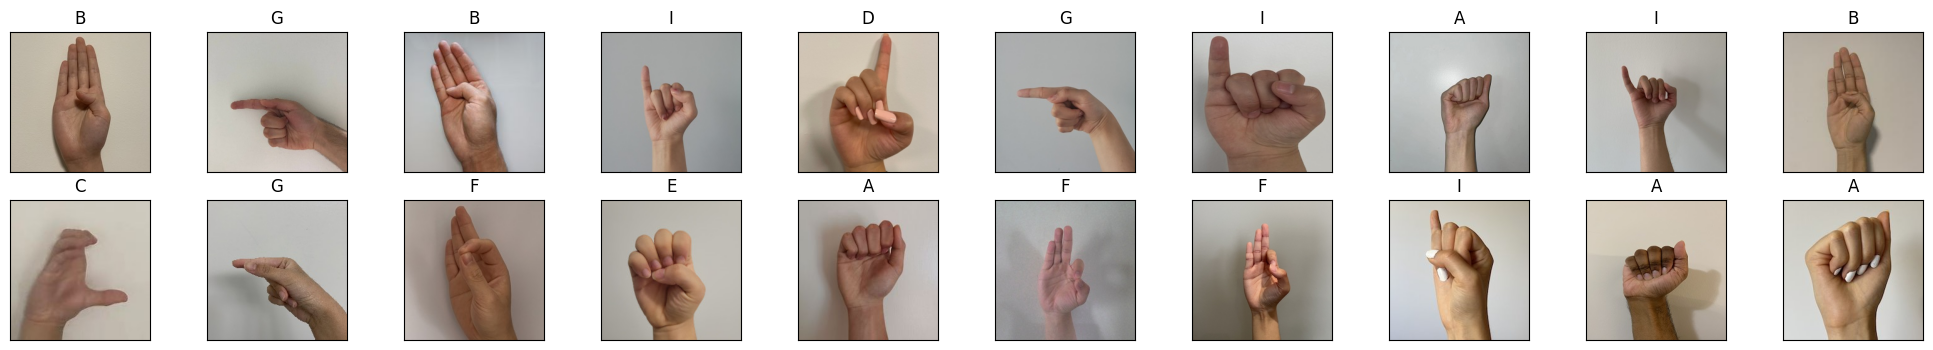

In [3]:
# define training and test data directories
data_dir = '/content/gdrive/MyDrive/APS360/AslPictures/'
train_dir = os.path.join(data_dir, 'Train/')
val_dir = os.path.join(data_dir, 'Val/')
test_dir = os.path.join(data_dir, 'Test/')

# classes are subfolders in each directory with these names
classes = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I']

# load and transform data using ImageFolder (with normalization)
data_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

train_data = datasets.ImageFolder(train_dir, transform=data_transform)
val_data = datasets.ImageFolder(val_dir, transform=data_transform)
test_data = datasets.ImageFolder(test_dir, transform=data_transform)

# print out some data stats
print('Num training images: ', len(train_data))
print('Num validation images: ', len(val_data))
print('Num test images: ', len(test_data))
print('Classes: ', classes)

# define dataloader parameters
batch_size = 32
num_workers = 2

# prepare data loaders with pin_memory for GPU acceleration
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                         num_workers=num_workers, shuffle=True,
                                         pin_memory=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size,
                                        num_workers=num_workers, shuffle=False,
                                        pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
                                        num_workers=num_workers, shuffle=False,
                                        pin_memory=True)

# Visualize a batch of training data
def visualize_batch(loader, num_images=8):
    dataiter = iter(train_loader)
    images, labels = next(dataiter)
    images = images.numpy() # convert images to numpy for display

    # plot the images in the batch, along with the corresponding labels
    fig = plt.figure(figsize=(25, 4))
    for idx in np.arange(20):
        ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[])
        plt.imshow(np.transpose(images[idx], (1, 2, 0)))
        ax.set_title(classes[labels[idx]])

# Visualize sample training images
visualize_batch(train_loader)

**Explanation**

I split the dataset manually into different folders in my drive. I put 80% of the given dataset [A through I] into the training folder, and then split the rest of the images, 10% in the test folders and 10% in the validation photos. I chose to split it this way since the model needs the most data as possible to learn patterns effectvley and then used smaller sets (10%) for the test data and validation data so it could quickly evaluate how good the model is without waiting the full training cycles.


### 2. Model Building and Sanity Checking [15 pt]

### Part (a) Convolutional Network - 5 pt

Build a convolutional neural network model that takes the (224x224 RGB) image as input, and predicts the gesture
letter. Your model should be a subclass of nn.Module. Explain your choice of neural network architecture: how
many layers did you choose? What types of layers did you use? Were they fully-connected or convolutional?
What about other decisions like pooling layers, activation functions, number of channels / hidden units?

In [4]:
class SimpleASLCNN(nn.Module):
    def __init__(self):
        super(SimpleASLCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 5, 5)  # in_channels, out_channels, kernel_size
        self.pool = nn.MaxPool2d(2, 2)  # kernel_size, stride
        self.conv2 = nn.Conv2d(5, 10, 5)  # in_channels, out_channels, kernel_size
        self.fc1 = nn.Linear(10 * 53 * 53, 32)
        self.fc2 = nn.Linear(32, 9)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 10 * 53 * 53)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

**Explanation**

I chose 2 convolutional layers to scan the input image using 5x5 filters. Between these layers I added max pooling layers to reduce the image size. I also added ReLU activations to help with non-linearity after each convolutional layer.


### Part (b) Training Code - 5 pt

Write code that trains your neural network given some training data. Your training code should make it easy
to tweak the usual hyperparameters, like batch size, learning rate, and the model object itself. Make sure
that you are checkpointing your models from time to time (the frequency is up to you). Explain your choice
of loss function and optimizer.

In [12]:
def train(model, train_data, val_data, batch_size=64, num_epochs=10, learning_rate=0.001, use_cuda=True):
    #initialize data loaders
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

    #loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    #tracking variables
    iters, losses, train_acc, val_acc = [], [], [], []
    n = 0  # Iteration counter
    start_time = time.time()

    #training loop
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        model.train()

        for imgs, labels in iter(train_loader):
            #enable GPU if available
            if use_cuda and torch.cuda.is_available():
                imgs = imgs.cuda()
                labels = labels.cuda()

            #forward pass
            out = model(imgs)
            loss = criterion(out, labels)
            epoch_loss += loss.item()

            #backward pass and loss
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            #save training information
            if n % 10 == 0:
                iters.append(n)
                losses.append(loss.item()/batch_size)

            n += 1

        #calculate accuracies at end of epoch
        epoch_train_acc = get_accuracy(model, train_loader)
        epoch_val_acc = get_accuracy(model, val_loader)
        train_acc.append(epoch_train_acc)
        val_acc.append(epoch_val_acc)

        #summary
        epoch_time = time.time() - start_time
        print(f"Epoch {epoch+1}/{num_epochs}: "
              f"Loss: {epoch_loss/len(train_loader):.4f}, "
              f"Train Acc: {epoch_train_acc*100:.2f}%, "
              f"Val Acc: {epoch_val_acc*100:.2f}%, "
              f"Time: {epoch_time/(epoch+1):.2f}s")

        #checkpoint every 2 epochs
        if (epoch + 1) % 2 == 0:
            model_path = f"asl_model_epoch{epoch+1}_bs{batch_size}_lr{learning_rate}.pth"
            torch.save(model.state_dict(), model_path)

    #statistics
    total_time = time.time() - start_time

    #plotting
    plt.figure(figsize=(12,4))


    plt.subplot(1,2,1)
    plt.title("Training Loss")
    plt.plot(iters, losses)
    plt.xlabel("Iterations")
    plt.ylabel("Loss")

    plt.subplot(1,2,2)
    plt.title("Accuracy")
    plt.plot(range(num_epochs), train_acc, label="Train")
    plt.plot(range(num_epochs), val_acc, label="Validation")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()

    print(f"\nTraining complete in {total_time/60:.2f} minutes")
    print(f"Final Training Accuracy: {train_acc[-1]*100:.2f}%")
    print(f"Final Validation Accuracy: {val_acc[-1]*100:.2f}%")

    return train_acc, val_acc, list(range(num_epochs))

def store_results(train_acc, val_acc, epochs, batch_size, learning_rate, num_epochs):
    return {
        'train_acc': train_acc,
        'val_acc': val_acc,
        'epochs': epochs,
        'config': {
            'batch_size': batch_size,
            'learning_rate': learning_rate,
            'num_epochs': num_epochs
        }
    }

def get_accuracy(model, data_loader):
    #return accuracy as a fraction (for test accuracy later on)
    correct = 0
    total = 0
    model.eval()

    with torch.no_grad():
        for imgs, labels in data_loader:
            if torch.cuda.is_available():
                imgs = imgs.cuda()
                labels = labels.cuda()

            outputs = model(imgs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return correct / total

### Part (c) “Overfit” to a Small Dataset - 5 pt

One way to sanity check our neural network model and training code is to check whether the model is capable
of “overfitting” or “memorizing” a small dataset. A properly constructed CNN with correct training code
should be able to memorize the answers to a small number of images quickly.

Construct a small dataset (e.g. just the images that you have collected). Then show that your model and
training code is capable of memorizing the labels of this small data set.

With a large batch size (e.g. the entire small dataset) and learning rate that is not too high, You should be
able to obtain a 100% training accuracy on that small dataset relatively quickly (within 200 iterations).

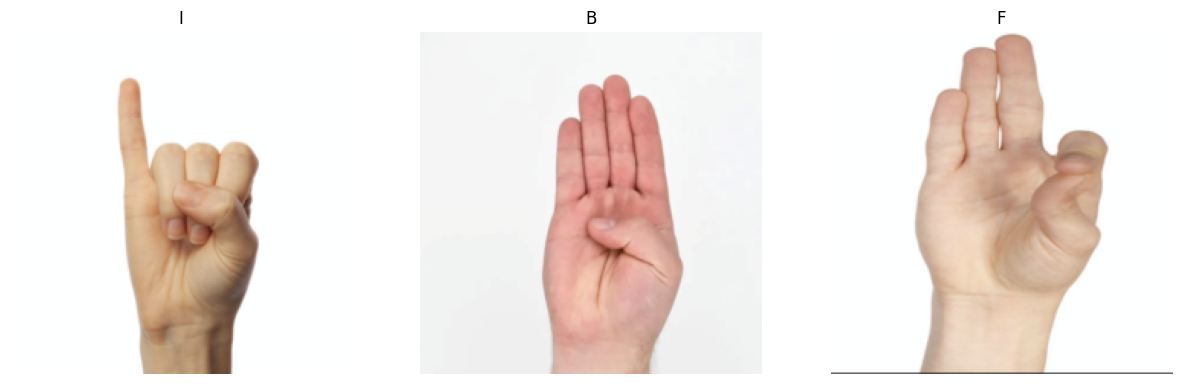

Training Started...
Epoch 1/50, Loss: 2.2079, Accuracy: 11.11%
Epoch 2/50, Loss: 2.6410, Accuracy: 11.11%
Epoch 3/50, Loss: 2.6373, Accuracy: 22.22%
Epoch 4/50, Loss: 2.2446, Accuracy: 22.22%
Epoch 5/50, Loss: 1.9662, Accuracy: 33.33%
Epoch 6/50, Loss: 1.9449, Accuracy: 33.33%
Epoch 7/50, Loss: 1.8626, Accuracy: 66.67%
Epoch 8/50, Loss: 1.7994, Accuracy: 55.56%
Epoch 9/50, Loss: 1.7238, Accuracy: 66.67%
Epoch 10/50, Loss: 1.6060, Accuracy: 77.78%
Epoch 11/50, Loss: 1.4720, Accuracy: 88.89%
Epoch 12/50, Loss: 1.3273, Accuracy: 77.78%
Epoch 13/50, Loss: 1.1934, Accuracy: 77.78%
Epoch 14/50, Loss: 1.0492, Accuracy: 77.78%
Epoch 15/50, Loss: 0.9022, Accuracy: 77.78%
Epoch 16/50, Loss: 0.7532, Accuracy: 88.89%
Epoch 17/50, Loss: 0.6091, Accuracy: 88.89%
Epoch 18/50, Loss: 0.4795, Accuracy: 100.00%
Reached 100% accuracy!


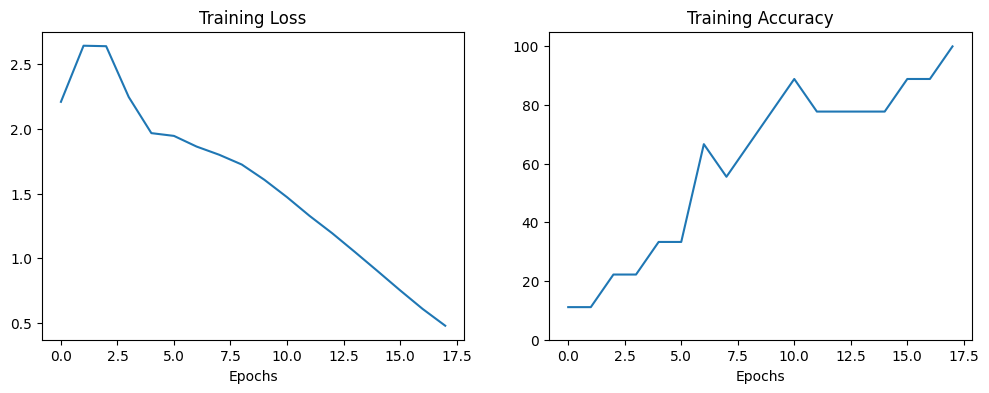

In [6]:
#check if CUDA is available
use_cuda = torch.cuda.is_available()

def overfit(model, train_loader, num_epochs=50, learn_rate=0.001):
    torch.manual_seed(10)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learn_rate)

    train_acc = []
    losses = []

    print("Training Started...")
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for imgs, labels in train_loader:
            if use_cuda:
                imgs = imgs.cuda()
                labels = labels.cuda()

            optimizer.zero_grad()
            out = model(imgs)
            loss = criterion(out, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        epoch_acc = get_accuracy(model, train_loader)
        train_acc.append(epoch_acc)
        losses.append(running_loss/len(train_loader))

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {losses[-1]:.4f}, Accuracy: {epoch_acc:.2f}%")

        if epoch_acc == 100:
            print("Reached 100% accuracy!")
            break

    return train_acc, losses

def get_accuracy(model, data_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for imgs, labels in data_loader:
            if use_cuda:
                imgs = imgs.cuda()
                labels = labels.cuda()

            outputs = model(imgs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    model.train()
    return 100 * correct / total

#set path
small_path = '/content/gdrive/MyDrive/APS360/AslPictures/smallDataset/'

#transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                       std=[0.229, 0.224, 0.225])
])

#load dataset
small_dataset = datasets.ImageFolder(small_path, transform=transform)

#use all data
batch_size = len(small_dataset)
small_loader = DataLoader(small_dataset, batch_size=batch_size, shuffle=True)

#visualize samples
def imshow(img, title=None):
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean  #unnormalize
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    if title:
        plt.title(title)
    plt.axis('off')

#show only first 3 images?
dataiter = iter(small_loader)
images, labels = next(dataiter)
images = images.cpu()

plt.figure(figsize=(15, 5))
for i in range(min(3, len(images))):
    plt.subplot(1, 3, i+1)
    imshow(images[i], title=small_dataset.classes[labels[i]])
plt.show()

#initialize and train model
model = SimpleASLCNN()
if use_cuda:
    model = model.cuda()

train_acc, losses = overfit(model, small_loader, num_epochs=50)

#plot
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(losses)
plt.title('Training Loss')
plt.xlabel('Epochs')

plt.subplot(1, 2, 2)
plt.plot(train_acc)
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylim([0, 105])
plt.show()

### 3. Hyperparameter Search [15 pt]

### Part (a) - 3 pt

List 3 hyperparameters that you think are most worth tuning. Choose at least one hyperparameter related to
the model architecture.

**Explanation**

I would tune the batch size, kernel size (which relates to the model's architecture), and learning rate.

### Part (b) - 5 pt

Tune the hyperparameters you listed in Part (a), trying as many values as you need to until you feel satisfied
that you are getting a good model. Plot the training curve of at least 4 different hyperparameter settings.

In [14]:
#edit the cnn so it's more flexible and I can edit the kernal values
class FlexibleASLCNN(nn.Module):
    def __init__(self, kernel_size=5):
        super(FlexibleASLCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 5, kernel_size)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 10, kernel_size)

        conv_output_size = ((224 - kernel_size + 1) // 2 - kernel_size + 1) // 2
        self.fc1 = nn.Linear(10 * conv_output_size * conv_output_size, 32)
        self.fc2 = nn.Linear(32, 9)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

TEST 1: Small Batch Size, Small Kernel
Epoch 1/10: Loss: 2.1974, Train Acc: 21.60%, Val Acc: 23.32%, Time: 49.94s
Epoch 2/10: Loss: 1.7884, Train Acc: 59.33%, Val Acc: 57.85%, Time: 49.55s
Epoch 3/10: Loss: 1.1568, Train Acc: 70.73%, Val Acc: 67.26%, Time: 49.46s
Epoch 4/10: Loss: 0.8933, Train Acc: 75.30%, Val Acc: 65.92%, Time: 49.72s
Epoch 5/10: Loss: 0.7819, Train Acc: 78.45%, Val Acc: 69.96%, Time: 49.92s
Epoch 6/10: Loss: 0.7110, Train Acc: 81.11%, Val Acc: 72.20%, Time: 49.96s
Epoch 7/10: Loss: 0.6380, Train Acc: 82.40%, Val Acc: 72.65%, Time: 50.00s
Epoch 8/10: Loss: 0.5491, Train Acc: 84.21%, Val Acc: 74.89%, Time: 50.12s
Epoch 9/10: Loss: 0.5081, Train Acc: 85.96%, Val Acc: 70.85%, Time: 50.11s
Epoch 10/10: Loss: 0.4085, Train Acc: 90.64%, Val Acc: 69.96%, Time: 50.26s


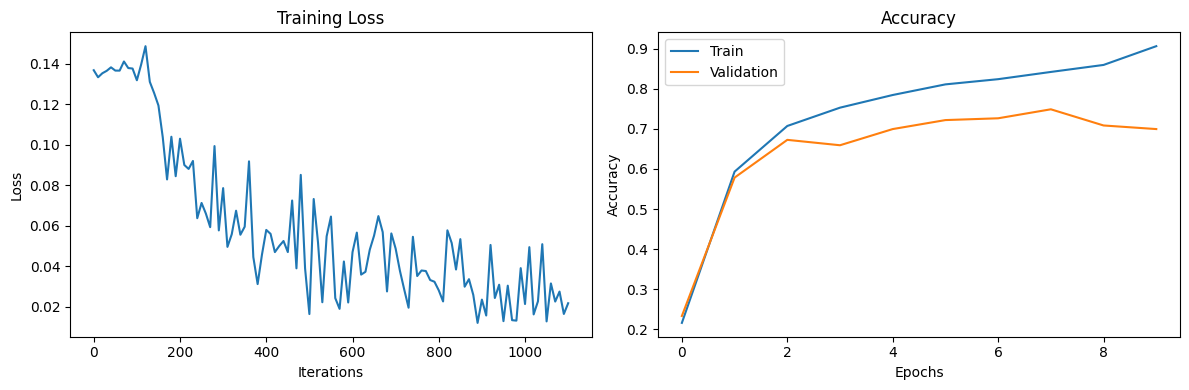


Training complete in 8.38 minutes
Final Training Accuracy: 90.64%
Final Validation Accuracy: 69.96%


In [15]:
print("TEST 1: Small Batch Size, Small Kernel")
model1 = FlexibleASLCNN(kernel_size=3)
if use_cuda:
    model1.cuda()

train_acc1, val_acc1, epochs1 = train(
    model1, train_data, val_data,
    batch_size=16, learning_rate=0.001, num_epochs=10,
    use_cuda=use_cuda
)
result1 = store_results(train_acc1, val_acc1, epochs1, 16, 0.001, 10)

TEST 2: Large Batch Size, Medium Kernel (original)
Epoch 1/10: Loss: 2.2448, Train Acc: 12.01%, Val Acc: 12.11%, Time: 72.66s
Epoch 2/10: Loss: 2.1984, Train Acc: 12.18%, Val Acc: 12.56%, Time: 71.05s
Epoch 3/10: Loss: 2.1955, Train Acc: 12.30%, Val Acc: 13.00%, Time: 70.97s
Epoch 4/10: Loss: 2.1851, Train Acc: 18.84%, Val Acc: 18.83%, Time: 70.91s
Epoch 5/10: Loss: 2.0822, Train Acc: 20.42%, Val Acc: 20.18%, Time: 70.88s
Epoch 6/10: Loss: 1.8403, Train Acc: 37.79%, Val Acc: 30.49%, Time: 71.07s
Epoch 7/10: Loss: 1.5644, Train Acc: 49.46%, Val Acc: 38.57%, Time: 71.07s
Epoch 8/10: Loss: 1.2712, Train Acc: 58.43%, Val Acc: 51.57%, Time: 71.16s
Epoch 9/10: Loss: 1.0696, Train Acc: 64.81%, Val Acc: 52.91%, Time: 71.26s
Epoch 10/10: Loss: 0.9503, Train Acc: 71.97%, Val Acc: 60.54%, Time: 71.31s


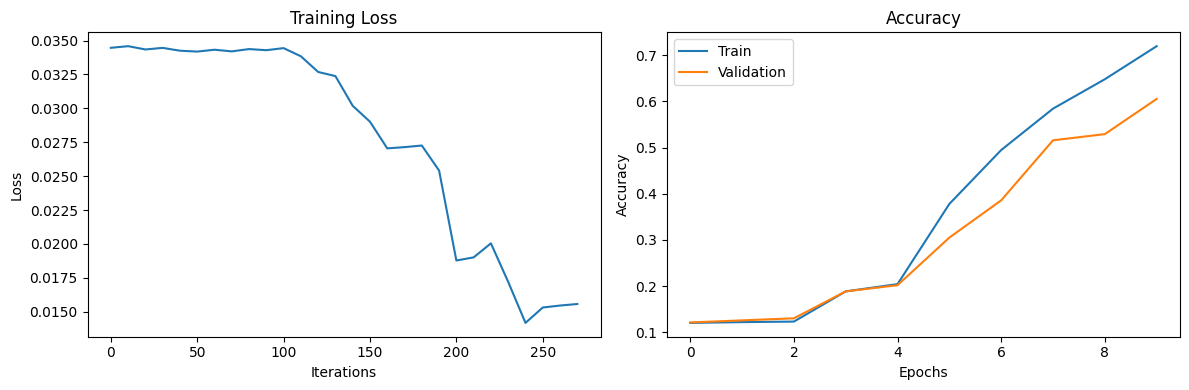


Training complete in 11.88 minutes
Final Training Accuracy: 71.97%
Final Validation Accuracy: 60.54%


In [16]:
# TEST 2: Large Batch Size, Medium Kernel
print("TEST 2: Large Batch Size, Medium Kernel (original)")
model2 = FlexibleASLCNN(kernel_size=5)
if use_cuda:
    model2.cuda()

train_acc2, val_acc2, epochs2 = train(
    model2, train_data, val_data,
    batch_size=64, learning_rate=0.001, num_epochs=10,
    use_cuda=use_cuda
)
result2 = store_results(train_acc2, val_acc2, epochs2, 64, 0.001, 10)


TEST 3: Higher Learning Rate, Large Kernel
Epoch 1/10: Loss: 2.2901, Train Acc: 11.28%, Val Acc: 11.21%, Time: 78.10s
Epoch 2/10: Loss: 2.1991, Train Acc: 11.00%, Val Acc: 11.21%, Time: 77.84s
Epoch 3/10: Loss: 2.1989, Train Acc: 11.11%, Val Acc: 11.21%, Time: 77.59s
Epoch 4/10: Loss: 2.1989, Train Acc: 11.45%, Val Acc: 11.66%, Time: 77.31s
Epoch 5/10: Loss: 2.1995, Train Acc: 11.45%, Val Acc: 11.66%, Time: 77.44s
Epoch 6/10: Loss: 2.1984, Train Acc: 11.28%, Val Acc: 11.21%, Time: 77.64s
Epoch 7/10: Loss: 2.1987, Train Acc: 11.45%, Val Acc: 11.66%, Time: 77.50s
Epoch 8/10: Loss: 2.1993, Train Acc: 11.45%, Val Acc: 11.66%, Time: 78.16s
Epoch 9/10: Loss: 2.1993, Train Acc: 11.45%, Val Acc: 11.66%, Time: 78.26s
Epoch 10/10: Loss: 2.1988, Train Acc: 11.11%, Val Acc: 11.21%, Time: 78.16s


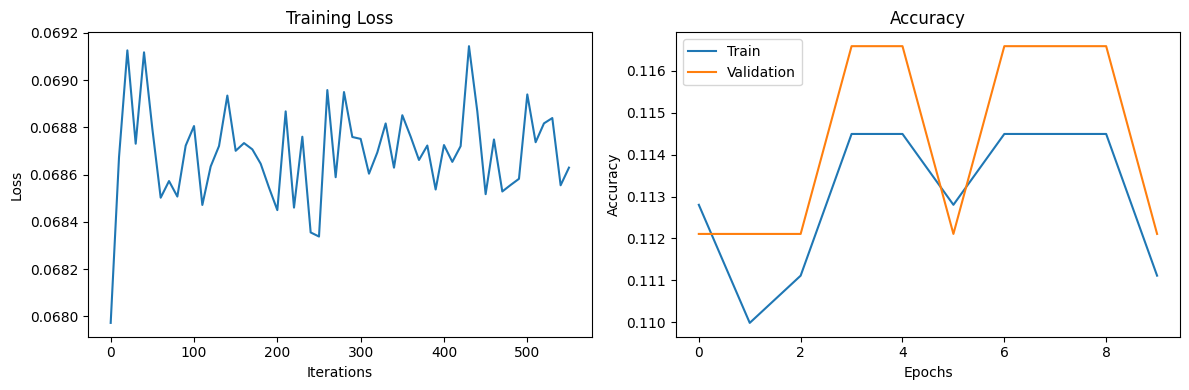


Training complete in 13.03 minutes
Final Training Accuracy: 11.11%
Final Validation Accuracy: 11.21%


In [17]:
print("TEST 3: Higher Learning Rate, Large Kernel")
model3 = FlexibleASLCNN(kernel_size=7)
if use_cuda:
    model3.cuda()

train_acc3, val_acc3, epochs3 = train(
    model3, train_data, val_data,
    batch_size=32, learning_rate=0.01, num_epochs=10,
    use_cuda=use_cuda
)
result3 = store_results(train_acc3, val_acc3, epochs3, 32, 0.01, 10)


TEST 4: Lower Learning Rate, Medium Kernel
Epoch 1/10: Loss: 2.2021, Train Acc: 11.11%, Val Acc: 11.21%, Time: 66.56s
Epoch 2/10: Loss: 2.1692, Train Acc: 14.16%, Val Acc: 13.45%, Time: 67.69s
Epoch 3/10: Loss: 2.1092, Train Acc: 26.79%, Val Acc: 27.35%, Time: 67.83s
Epoch 4/10: Loss: 2.0287, Train Acc: 27.58%, Val Acc: 22.87%, Time: 68.12s
Epoch 5/10: Loss: 1.9576, Train Acc: 22.90%, Val Acc: 21.52%, Time: 68.23s
Epoch 6/10: Loss: 1.8880, Train Acc: 28.26%, Val Acc: 26.01%, Time: 68.19s
Epoch 7/10: Loss: 1.8498, Train Acc: 28.14%, Val Acc: 28.25%, Time: 68.17s
Epoch 8/10: Loss: 1.7917, Train Acc: 27.47%, Val Acc: 25.11%, Time: 68.11s
Epoch 9/10: Loss: 1.7510, Train Acc: 27.52%, Val Acc: 26.46%, Time: 68.24s
Epoch 10/10: Loss: 1.7013, Train Acc: 31.75%, Val Acc: 30.94%, Time: 68.51s


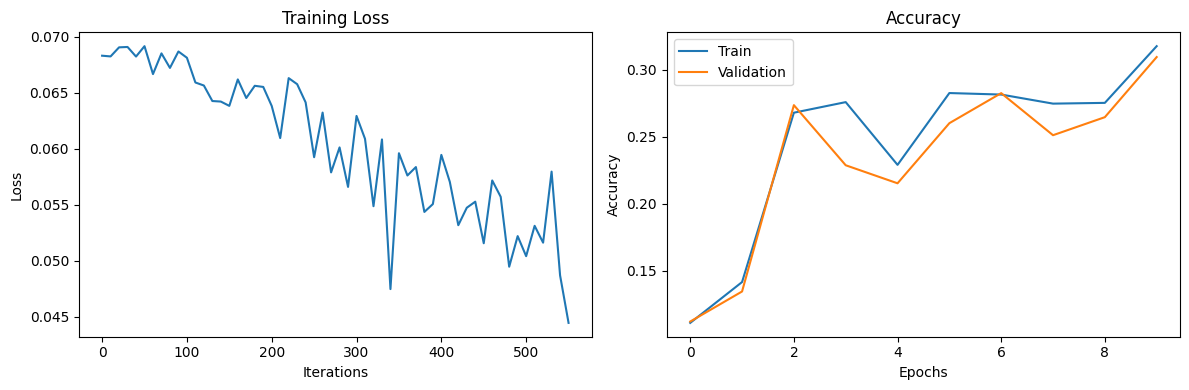


Training complete in 11.42 minutes
Final Training Accuracy: 31.75%
Final Validation Accuracy: 30.94%


In [18]:
print("TEST 4: Lower Learning Rate, Medium Kernel")
model4 = FlexibleASLCNN(kernel_size=5)
if use_cuda:
    model4.cuda()

train_acc4, val_acc4, epochs4 = train(
    model4, train_data, val_data,
    batch_size=32, learning_rate=0.0001, num_epochs=10,
    use_cuda=use_cuda
)
result4 = store_results(train_acc4, val_acc4, epochs4, 32, 0.0001, 10)


TEST 7: Tried increasing epochs - more learning time + less batch + less LR
Epoch 1/20: Loss: 2.1137, Train Acc: 29.44%, Val Acc: 35.87%, Time: 60.40s
Epoch 2/20: Loss: 1.6000, Train Acc: 52.51%, Val Acc: 48.43%, Time: 60.18s
Epoch 3/20: Loss: 1.3212, Train Acc: 60.07%, Val Acc: 58.74%, Time: 60.25s
Epoch 4/20: Loss: 1.1182, Train Acc: 64.52%, Val Acc: 56.05%, Time: 60.18s
Epoch 5/20: Loss: 1.0103, Train Acc: 66.50%, Val Acc: 58.74%, Time: 60.40s
Epoch 6/20: Loss: 0.9056, Train Acc: 72.53%, Val Acc: 66.82%, Time: 60.39s
Epoch 7/20: Loss: 0.8398, Train Acc: 75.69%, Val Acc: 70.40%, Time: 60.33s
Epoch 8/20: Loss: 0.8290, Train Acc: 74.90%, Val Acc: 66.82%, Time: 60.41s
Epoch 9/20: Loss: 0.7906, Train Acc: 75.80%, Val Acc: 70.40%, Time: 60.41s
Epoch 10/20: Loss: 0.7244, Train Acc: 76.03%, Val Acc: 71.30%, Time: 60.45s
Epoch 11/20: Loss: 0.7033, Train Acc: 79.19%, Val Acc: 69.06%, Time: 60.55s
Epoch 12/20: Loss: 0.6635, Train Acc: 79.08%, Val Acc: 70.85%, Time: 60.49s
Epoch 13/20: Loss: 0.

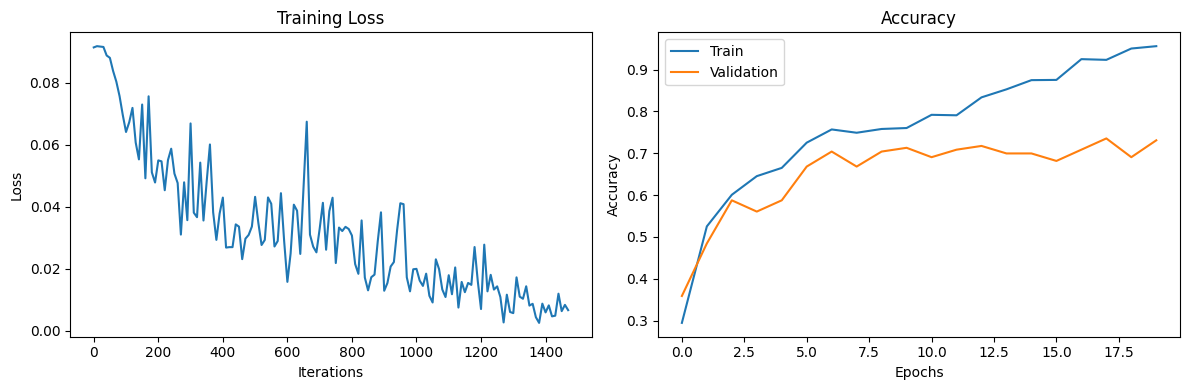


Training complete in 20.19 minutes
Final Training Accuracy: 95.60%
Final Validation Accuracy: 73.09%


In [19]:
print("TEST 7: Tried increasing epochs - more learning time + less batch + less LR")
model7 = FlexibleASLCNN(kernel_size=5)
if use_cuda:
    model7.cuda()

train_acc7, val_acc7, epochs7 = train(
    model7, train_data, val_data,
    batch_size=24, learning_rate=0.0015, num_epochs=20,
    use_cuda=use_cuda
)
result7 = store_results(train_acc7, val_acc7, epochs7, 24, 0.0015, 18)


### Part (c) - 3 pt
Choose the best model out of all the ones that you have trained. Justify your choice.

**Explanation**

My best model that I've trained was the very last one. I tested a larger epoch so it had a longer training time, a lower learning rate because compared to when I raised the LR to when I lowered it, the lower one scored better, and finally, I also used a smaller batch size because during the first 2 tests where I increased the batch size and lowered it, the smaller BS scored better.

### Part (d) - 4 pt
Report the test accuracy of your best model. You should only do this step once and prior to this step you should have only used the training and validation data.

In [22]:
# Use TEST 7 model as best
print("Best Model: TEST 7 - BatchSize = 24, Learning Rate = 0.0015, Kernel = 5, epoch = 20")

test_loader = DataLoader(test_data, batch_size=24, shuffle=False)
test_accuracy = get_accuracy(model7, test_loader)

print(f"FINAL TEST ACCURACY: {test_accuracy*100:.2f}%")


Best Model: TEST 7 - BatchSize = 24, Learning Rate = 0.0015, Kernel = 5, epoch = 20
FINAL TEST ACCURACY: 58.74%


### 4. Transfer Learning [15 pt]
For many image classification tasks, it is generally not a good idea to train a very large deep neural network
model from scratch due to the enormous compute requirements and lack of sufficient amounts of training
data.

One of the better options is to try using an existing model that performs a similar task to the one you need
to solve. This method of utilizing a pre-trained network for other similar tasks is broadly termed **Transfer
Learning**. In this assignment, we will use Transfer Learning to extract features from the hand gesture
images. Then, train a smaller network to use these features as input and classify the hand gestures.

As you have learned from the CNN lecture, convolution layers extract various features from the images which
get utilized by the fully connected layers for correct classification. AlexNet architecture played a pivotal
role in establishing Deep Neural Nets as a go-to tool for image classification problems and we will use an
ImageNet pre-trained AlexNet model to extract features in this assignment.

### Part (a) - 5 pt
Here is the code to load the AlexNet network, with pretrained weights. When you first run the code, PyTorch
will download the pretrained weights from the internet.

In [23]:
import torchvision.models
alexnet = torchvision.models.alexnet(pretrained=True)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:02<00:00, 101MB/s]


The alexnet model is split up into two components: *alexnet.features* and *alexnet.classifier*. The
first neural network component, *alexnet.features*, is used to compute convolutional features, which are
taken as input in *alexnet.classifier*.

The neural network alexnet.features expects an image tensor of shape Nx3x224x224 as input and it will
output a tensor of shape Nx256x6x6 . (N = batch size).

Compute the AlexNet features for each of your training, validation, and test data. Here is an example code
snippet showing how you can compute the AlexNet features for some images (your actual code might be
different):

In [25]:
#load AlexNet
import torchvision.models
alexnet = torchvision.models.alexnet(weights='IMAGENET1K_V1')

#compute features
print("Extracting training features...")
train_features_list = []
train_labels_list = []
for img, labels in train_loader:
    features = alexnet.features(img)  # input: Nx3x224x224, output: Nx256x6x6
    train_features_list.append(features.detach().numpy())
    train_labels_list.append(labels.numpy())

print("Extracting validation features...")
val_features_list = []
val_labels_list = []
for img, labels in val_loader:
    features = alexnet.features(img)
    val_features_list.append(features.detach().numpy())
    val_labels_list.append(labels.numpy())

print("Extracting test features...")
test_features_list = []
test_labels_list = []
for img, labels in test_loader:
    features = alexnet.features(img)
    test_features_list.append(features.detach().numpy())
    test_labels_list.append(labels.numpy())

#combine all batches
train_features = np.concatenate(train_features_list, axis=0)
train_labels = np.concatenate(train_labels_list, axis=0)
val_features = np.concatenate(val_features_list, axis=0)
val_labels = np.concatenate(val_labels_list, axis=0)
test_features = np.concatenate(test_features_list, axis=0)
test_labels = np.concatenate(test_labels_list, axis=0)

print(f"Training features shape: {train_features.shape}")
print(f"Validation features shape: {val_features.shape}")
print(f"Test features shape: {test_features.shape}")


Extracting training features...
Extracting validation features...
Extracting test features...
Training features shape: (1773, 256, 6, 6)
Validation features shape: (223, 256, 6, 6)
Test features shape: (223, 256, 6, 6)


**Save the computed features**. You will be using these features as input to your neural network in Part
(b), and you do not want to re-compute the features every time. Instead, run *alexnet.features* once for
each image, and save the result.

In [27]:
# save
print("Saving features...")
np.save('train_alexnet_features.npy', train_features)
np.save('train_labels.npy', train_labels)
np.save('val_alexnet_features.npy', val_features)
np.save('val_labels.npy', val_labels)
np.save('test_alexnet_features.npy', test_features)
np.save('test_labels.npy', test_labels)
print("Done!")

Saving features...
Done!


### Part (b) - 3 pt
Build a convolutional neural network model that takes as input these AlexNet features, and makes a
prediction. Your model should be a subclass of nn.Module.

Explain your choice of neural network architecture: how many layers did you choose? What types of layers
did you use: fully-connected or convolutional? What about other decisions like pooling layers, activation
functions, number of channels / hidden units in each layer?

Here is an example of how your model may be called:

In [31]:
# features = ... load precomputed alexnet.features(img) ...
#output = model(features)
#prob = F.softmax(output)

torch.manual_seed(5)
from math import floor

class AlexNetClassifier(nn.Module):
    def __init__(self, name = "AlexNet_Classifier"):
        super(AlexNetClassifier, self).__init__()
        self.conv1 = nn.Conv2d(256, 512, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.x = floor((6 - 3 + 1)/2)
        self.FC_input = 512*self.x*self.x

        self.fc1 = nn.Linear(self.FC_input, 32)
        self.fc2 = nn.Linear(32, 9)
        self.name = name

    def forward(self, features):
        x = self.pool(F.relu(self.conv1(features)))
        x = x.view(-1, self.FC_input)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1)

**Explanation**

I decided to use only 1 convolutional layer, a pooling layer, and 2 fully connected layers this time because AlexNet features are already high-level so I don't think we don't need many layers. I also used ReLu to help with non-linear transformations.

### Part (c) - 5 pt
Train your new network, including any hyperparameter tuning. Plot and submit the training curve of your
best model only.

Note: Depending on how you are caching (saving) your AlexNet features, PyTorch might still be tracking
updates to the **AlexNet weights**, which we are not tuning. One workaround is to convert your AlexNet
feature tensor into a numpy array, and then back into a PyTorch tensor.

In [32]:
#tensor = torch.from_numpy(tensor.detach().numpy())

#load the saved AlexNet features from above
print("Loading AlexNet features...")
train_features = np.load('train_alexnet_features.npy')
train_labels = np.load('train_labels.npy')
val_features = np.load('val_alexnet_features.npy')
val_labels = np.load('val_labels.npy')
test_features = np.load('test_alexnet_features.npy')
test_labels = np.load('test_labels.npy')

#convert to PyTorch tensors as suggested
train_features_tensor = torch.from_numpy(train_features).float()
train_labels_tensor = torch.from_numpy(train_labels).long()
val_features_tensor = torch.from_numpy(val_features).float()
val_labels_tensor = torch.from_numpy(val_labels).long()
test_features_tensor = torch.from_numpy(test_features).float()
test_labels_tensor = torch.from_numpy(test_labels).long()

print(f"Training features shape: {train_features_tensor.shape}")
print(f"Training labels shape: {train_labels_tensor.shape}")

#datasets features
from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(train_features_tensor, train_labels_tensor)
val_dataset = TensorDataset(val_features_tensor, val_labels_tensor)
test_dataset = TensorDataset(test_features_tensor, test_labels_tensor)

#cuda availability
use_cuda = torch.cuda.is_available()
print(f"Using CUDA: {use_cuda}")

#training function
def train_alexnet(model, train_data, val_data, batch_size=32, num_epochs=30, learning_rate=0.001, use_cuda=True):
    #initialize data loaders
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

    #loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    #tracking variables
    iters, losses, train_acc, val_acc = [], [], [], []
    n = 0  #iteration counter
    start_time = time.time()

    #training loop
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        model.train()

        for features, labels in iter(train_loader):
            #GPU if available
            if use_cuda and torch.cuda.is_available():
                features = features.cuda()
                labels = labels.cuda()

            #forward pass
            out = model(features)
            loss = criterion(out, labels)
            epoch_loss += loss.item()

            #backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            #save training information
            if n % 10 == 0:
                iters.append(n)
                losses.append(loss.item()/batch_size)

            n += 1

        #calculate accuracies at end of epoch
        epoch_train_acc = get_accuracy_alexnet(model, train_loader, use_cuda)
        epoch_val_acc = get_accuracy_alexnet(model, val_loader, use_cuda)
        train_acc.append(epoch_train_acc)
        val_acc.append(epoch_val_acc)

        #summary
        epoch_time = time.time() - start_time
        print(f"Epoch {epoch+1}/{num_epochs}: "
              f"Loss: {epoch_loss/len(train_loader):.4f}, "
              f"Train Acc: {epoch_train_acc*100:.2f}%, "
              f"Val Acc: {epoch_val_acc*100:.2f}%, "
              f"Time: {epoch_time/(epoch+1):.2f}s")

        #save checkpoint
        if (epoch + 1) % 5 == 0:
            model_path = f"alexnet_model_epoch{epoch+1}_bs{batch_size}_lr{learning_rate}.pth"
            torch.save(model.state_dict(), model_path)

    #statistics
    total_time = time.time() - start_time

    #plotting
    plt.figure(figsize=(12,4))

    #loss curve
    plt.subplot(1,2,1)
    plt.title("Training Loss")
    plt.plot(iters, losses)
    plt.xlabel("Iterations")
    plt.ylabel("Loss")

    #accuracy curve
    plt.subplot(1,2,2)
    plt.title("Accuracy")
    plt.plot(range(num_epochs), train_acc, label="Train")
    plt.plot(range(num_epochs), val_acc, label="Validation")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()

    print(f"\nTraining complete in {total_time/60:.2f} minutes")
    print(f"Final Training Accuracy: {train_acc[-1]*100:.2f}%")
    print(f"Final Validation Accuracy: {val_acc[-1]*100:.2f}%")

    return train_acc, val_acc, list(range(num_epochs))

def get_accuracy_alexnet(model, data_loader, use_cuda=True):
    correct = 0
    total = 0
    model.eval()

    with torch.no_grad():
        for features, labels in data_loader:
            if use_cuda and torch.cuda.is_available():
                features = features.cuda()
                labels = labels.cuda()

            outputs = model(features)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return correct / total

def store_results_alexnet(train_acc, val_acc, epochs, batch_size, learning_rate, num_epochs):
    return {
        'train_acc': train_acc,
        'val_acc': val_acc,
        'epochs': epochs,
        'config': {
            'batch_size': batch_size,
            'learning_rate': learning_rate,
            'num_epochs': num_epochs
        }
    }


Loading AlexNet features...
Training features shape: torch.Size([1773, 256, 6, 6])
Training labels shape: torch.Size([1773])
Using CUDA: False


Epoch 1/25: Loss: 1.8707, Train Acc: 69.49%, Val Acc: 66.37%, Time: 9.87s
Epoch 2/25: Loss: 1.6570, Train Acc: 74.11%, Val Acc: 71.30%, Time: 9.33s
Epoch 3/25: Loss: 1.6303, Train Acc: 75.47%, Val Acc: 71.75%, Time: 9.40s
Epoch 4/25: Loss: 1.6297, Train Acc: 75.80%, Val Acc: 73.54%, Time: 9.54s
Epoch 5/25: Loss: 1.6188, Train Acc: 76.03%, Val Acc: 74.44%, Time: 9.38s
Epoch 6/25: Loss: 1.6103, Train Acc: 76.65%, Val Acc: 71.30%, Time: 9.40s
Epoch 7/25: Loss: 1.6060, Train Acc: 76.93%, Val Acc: 73.54%, Time: 9.58s
Epoch 8/25: Loss: 1.6027, Train Acc: 76.31%, Val Acc: 74.89%, Time: 9.68s
Epoch 9/25: Loss: 1.6200, Train Acc: 79.58%, Val Acc: 75.78%, Time: 9.63s
Epoch 10/25: Loss: 1.5509, Train Acc: 84.04%, Val Acc: 76.23%, Time: 9.72s
Epoch 11/25: Loss: 1.5163, Train Acc: 83.59%, Val Acc: 80.27%, Time: 9.79s
Epoch 12/25: Loss: 1.5113, Train Acc: 87.37%, Val Acc: 82.96%, Time: 9.79s
Epoch 13/25: Loss: 1.4816, Train Acc: 96.16%, Val Acc: 92.83%, Time: 9.84s
Epoch 14/25: Loss: 1.4050, Train A

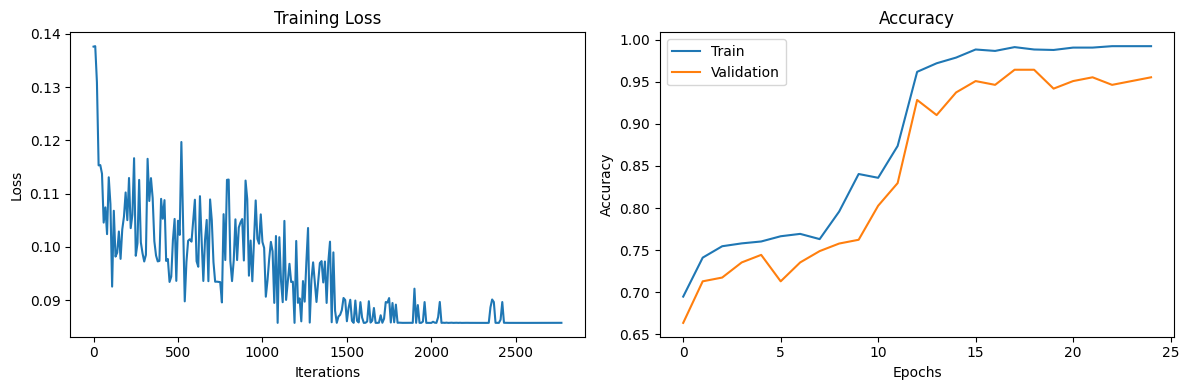


Training complete in 4.20 minutes
Final Training Accuracy: 99.21%
Final Validation Accuracy: 95.52%


In [36]:
#start tuning hyperparameters

results = []

model1 = AlexNetClassifier(name="AlexNet_SmallBatch")
if use_cuda:
    model1.cuda()

train_acc1, val_acc1, epochs1 = train_alexnet(
    model1, train_dataset, val_dataset,
    batch_size=16, learning_rate=0.001, num_epochs=25,
    use_cuda=use_cuda
)

result1 = store_results_alexnet(train_acc1, val_acc1, epochs1, 16, 0.001, 25)
results.append(result1)


### Part (d) - 2 pt
Report the test accuracy of your best model. How does the test accuracy compare to Part 3(d) without transfer learning?

In [37]:
#use model1 ask best model

print("Best Model w/ AlexNet Transfer Learning: BatchSize = 16, Learning Rate = 0.001, Epochs = 25")

test_loader_alexnet = DataLoader(test_dataset, batch_size=16, shuffle=False)
test_accuracy_transfer = get_accuracy_alexnet(model1, test_loader_alexnet, use_cuda)

print(f"FINAL TEST ACCURACY (with Transfer Learning): {test_accuracy_transfer*100:.2f}%")

Best Model w/ AlexNet Transfer Learning: BatchSize = 16, Learning Rate = 0.001, Epochs = 25
FINAL TEST ACCURACY (with Transfer Learning): 91.93%


**Explanation**

As you can see, the test accuracy with the transfer learning is exceptionally higher at around 90% compared to the test accuracy in part 3d which was only around 60% which is good!